https://medium.com/@lorevanoudenhove/enhancing-rag-performance-with-metadata-the-power-of-self-query-retrievers-e29d4eecdb73

Enhancing RAG Performance with Metadata: The Power of Self-Query Retrievers

Self-Query Retriever
The Self-Query Retriever is an advanced retrieval technique that allows for filtering documents based on metadata before performing similarity calculations. This method involves two key steps:

Query Constructor: This step involves creating an appropriate query and metadata filters based on the user input. A Language Model (LLM) is used to determine which filters to apply, ensuring that only relevant documents are considered.
Query Translator: This module translates the output of the Query Constructor into a format that can be understood by the vector database, in this case, Pinecone. It applies the necessary filters and performs the similarity search.

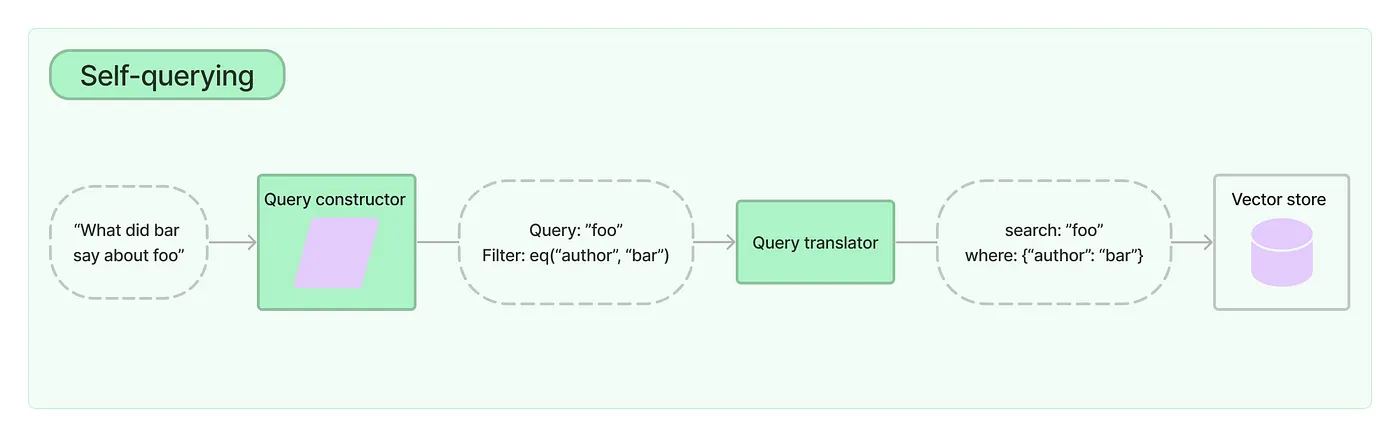



1.Define and Extract Metadata Fields: Clearly define the metadata fields available in your dataset. For climate data, these could include year and country.

Here’s how to define and extract the metadata fields from filenames:

In [ ]:
from langchain_classic.chains.query_constructor.base import AttributeInfo
from langchain_community.document_loaders import DirectoryLoader
from langchain_classic.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_community.embeddings import BedrockEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain_classic.chains.query_constructor.base import AttributeInfo
from langchain_classic.llms import OpenAI
from langchain_classic.retrievers import SelfQueryRetriever
from pinecone import Pinecone
import boto3
import os

# Define metadata fields
metadata_field_info = [
    AttributeInfo(
        name="year",
        description="The year of the climate report.",
        type="string",
    ),
    AttributeInfo(
        name="country",
        description="The country of the climate report",
        type="string",
    ),
]

# Function to extract metadata from filepath
def extract_metadata_from_filepath(filepath):
    filename = os.path.basename(filepath)
    parts = filename.split('_')
    year = parts[1]
    country = parts[2].split('.')[0]
    return {"year": year, "country": country}

def chunk_data(data):
    ''' Function to split documents into chunks '''
    text_splitter = RecursiveCharacterTextSplitter(chunk_size=4000, chunk_overlap=100)
    chunks = text_splitter.split_documents(data)
    return chunks

def get_bedrock_client(region):
    ''' Function to create a Bedrock client via boto3 '''
    bedrock_client = boto3.client("bedrock-runtime", region_name=region)
    return bedrock_client

def create_embeddings(region):
    ''' Function to create vector embeddings '''
    bedrock_client = get_bedrock_client(region)
    bedrock_embeddings = BedrockEmbeddings(model_id="amazon.titan-embed-text-v1",
                                           client=bedrock_client)
    return bedrock_embeddings

def stuff_vectordatabase(chunks, bedrock_embeddings, index_name):
    ''' Function to load the chunks into the vector database '''
    docsearch = PineconeVectorStore.from_documents(chunks, bedrock_embeddings, index_name=index_name)
    return docsearch

# Define a custom CSVLoader function to pass pandas_kwargs
def create_csv_loader(file_path):
    # return CSVLoader(file_path, pandas_kwargs={'low_memory': False})
    return CSVLoader(file_path , csv_args={'low_memory': False})

def main():
    print("### Load data from local directory")
    loader = DirectoryLoader('/Users/vkdvamshi/Downloads/backup/', glob="*.csv")
    data = loader.load()

    print("### Parse all documents in the database")
    for doc in data:
        metadata = extract_metadata_from_filepath(doc.metadata['source'])
        doc.metadata.update(metadata)

    print("### Split data into chunks")
    chunks = chunk_data(data)

    print("### Create embeddings model")
    embeddings = create_embeddings(region='us-east-1')

    print("### Load data into vector database")
    index_name = 'tutorial'
    stuff_vectordatabase(chunks, embeddings, index_name)

    print("### Done!")

if __name__ == "__main__":
    main()

: 